# XGBoost

##################################################################1 번째 fold
기본적인 다른 평가:
정확도: 0.7083, 정밀도: 0.7273, 재현율: 0.6667,          F1: 0.6957, AUC:0.8403
##################################################################2 번째 fold
기본적인 다른 평가:
정확도: 0.8333, 정밀도: 0.7857, 재현율: 0.9167,          F1: 0.8462, AUC:0.9028
##################################################################3 번째 fold
기본적인 다른 평가:
정확도: 0.7083, 정밀도: 0.7778, 재현율: 0.5833,          F1: 0.6667, AUC:0.7847
##################################################################4 번째 fold
기본적인 다른 평가:
정확도: 0.7917, 정밀도: 0.7333, 재현율: 0.9167,          F1: 0.8148, AUC:0.9167
##################################################################5 번째 fold
기본적인 다른 평가:
정확도: 0.8333, 정밀도: 0.8333, 재현율: 0.8333,          F1: 0.8333, AUC:0.8264


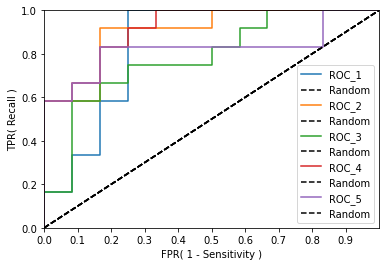

In [61]:
import pandas as pd
import numpy as np
final_input_table = pd.read_csv('./sungbin/9_2_final_4hour_check.csv')
# final_input_table.ETHNICITY.value_counts()
# final_input_table= final_input_table.iloc[:,:-2]
final_input_table

# 인종 레이블 인코딩
from sklearn.preprocessing import LabelEncoder



encoder=LabelEncoder()
encoder.fit(final_input_table.ETHNICITY)
labels = encoder.transform(final_input_table.ETHNICITY)
# print(labels)

final_input_table['new_ethnicity']=labels
final_input_table

# 성별 레이블 인코딩
encoder=LabelEncoder()
encoder.fit(final_input_table.GENDER)
gender = encoder.transform(final_input_table.GENDER)
# print(gender)

final_input_table['new_gender']=gender
final_input_table

encoding_input_table = final_input_table.drop(columns=['ETHNICITY','GENDER','renew_time','ICU'])
encoding_input_table

encoding_input_table = encoding_input_table.reset_index(drop=False)
encoding_input_table

import random
idx_ls = list(encoding_input_table[encoding_input_table['class'] == 0.].index)
idx_ls_1 = list(encoding_input_table[encoding_input_table['class'] == 1.].index)
samp = random.sample(idx_ls, 60)
# print(len(samp))
# len(np.unique(samp))
samp += idx_ls_1
samp = np.array(samp)

# print(samp), len(samp)

samp_df = pd.DataFrame(samp, columns=['index'])
samp_df

down_samp_input = pd.merge(samp_df, encoding_input_table, on='index', how='inner')
down_samp_input = down_samp_input.drop(columns=['index'])
down_samp_input

# XGBoost
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score , recall_score , confusion_matrix, f1_score

import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# dt_clf = DecisionTreeClassifier()
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
skfold = StratifiedKFold(n_splits=5)
n_iter = 0

features = down_samp_input.drop(columns=['class','new_time']).values
label = down_samp_input['class']


def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
#     print('오차 행렬')
#     print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))



def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
def roc_curve_plot_all(y_test, pred_proba_c1, n_iter):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label=f'ROC_{n_iter}')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

def feature_importance(estimator):

    # feature importance
    ftr_importances_values = estimator.feature_importances_
    # print(ftr_importance_values)
    # Series로 변환
    ftr_importances = pd.Series(ftr_importances_values, index=down_samp_input.drop(columns=['class','new_time']).columns)

    # 중요도 순으로 정렬
    ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]
    # print(ftr_top20)

    plt.figure(figsize=(8,6))
    plt.title('Feature importances TOP 15')
    sns.barplot(x=ftr_top15, y=ftr_top15.index)
    plt.show()

for train_index, test_index in skfold.split(features, label):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    
    n_iter += 1
    print(f'##################################################################{n_iter} 번째 fold')
    
#     print('학습셋 라벨 분포 \n', y_train.value_counts())
#     print('테스트셋 라벨 분포 \n', y_test.value_counts(),'\n')
    
    
    
    # 학습 및 예측
    xgb_wrapper.fit(X_train, y_train)
    pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
    pred = xgb_wrapper.predict(X_test)
    
    # 반복 마다 평가하기
    roc_curve_plot_all(y_test, pred_proba, n_iter) # 그림
    roc_score = roc_auc_score(y_test, pred_proba)
#     print('ROC AUC 값 : {0:.4f}'.format(roc_score),'\n')
    print('기본적인 다른 평가:')
    get_clf_eval(y_test, pred, pred_proba)
    
    # feature importance 구하기
#     feature_importance(xgb_wrapper)

    
    
    
    



##################################################################1 번째 fold
기본적인 다른 평가:
오차 행렬
[[6 6]
 [3 9]]
정확도: 0.6250, 정밀도: 0.6000, 재현율: 0.7500,          F1: 0.6667, AUC:0.7222


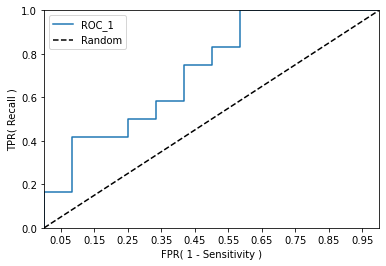

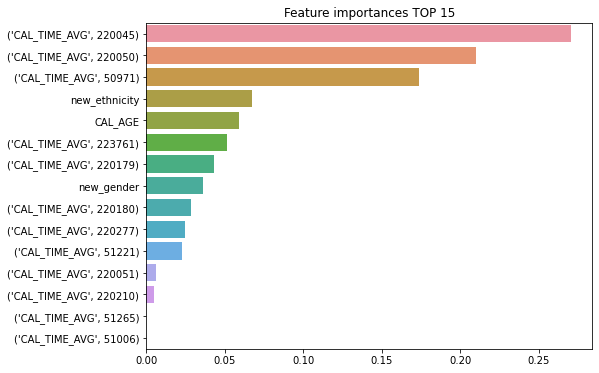

In [170]:
import pandas as pd
import numpy as np
final_input_table = pd.read_csv('./sungbin/9_2_final_4hour_check.csv')
# final_input_table.ETHNICITY.value_counts()
# final_input_table= final_input_table.iloc[:,:-2]
final_input_table

# 인종 레이블 인코딩
from sklearn.preprocessing import LabelEncoder



encoder=LabelEncoder()
encoder.fit(final_input_table.ETHNICITY)
labels = encoder.transform(final_input_table.ETHNICITY)
# print(labels)

final_input_table['new_ethnicity']=labels
final_input_table

# 성별 레이블 인코딩
encoder=LabelEncoder()
encoder.fit(final_input_table.GENDER)
gender = encoder.transform(final_input_table.GENDER)
# print(gender)

final_input_table['new_gender']=gender
final_input_table

encoding_input_table = final_input_table.drop(columns=['ETHNICITY','GENDER','renew_time','ICU'])
encoding_input_table

encoding_input_table = encoding_input_table.reset_index(drop=False)
encoding_input_table

import random
idx_ls = list(encoding_input_table[encoding_input_table['class'] == 0.].index)
idx_ls_1 = list(encoding_input_table[encoding_input_table['class'] == 1.].index)
samp = random.sample(idx_ls, 60)
# print(len(samp))
# len(np.unique(samp))
samp += idx_ls_1
samp = np.array(samp)

# print(samp), len(samp)

samp_df = pd.DataFrame(samp, columns=['index'])
samp_df

down_samp_input = pd.merge(samp_df, encoding_input_table, on='index', how='inner')
down_samp_input = down_samp_input.drop(columns=['index'])
down_samp_input

# XGBoost
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score , recall_score , confusion_matrix, f1_score

import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# dt_clf = DecisionTreeClassifier()
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
skfold = StratifiedKFold(n_splits=5)
n_iter = 0

features = down_samp_input.drop(columns=['class','new_time']).values
label = down_samp_input['class']


def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))



def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
def roc_curve_plot_all(y_test, pred_proba_c1, n_iter):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label=f'ROC_{n_iter}')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

def feature_importance(estimator):

    # feature importance
    ftr_importances_values = estimator.feature_importances_
    # print(ftr_importance_values)
    # Series로 변환
    ftr_importances = pd.Series(ftr_importances_values, index=down_samp_input.drop(columns=['class','new_time']).columns)

    # 중요도 순으로 정렬
    ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]
    # print(ftr_top20)

    plt.figure(figsize=(8,6))
    plt.title('Feature importances TOP 15')
    sns.barplot(x=ftr_top15, y=ftr_top15.index)
    plt.show()

for train_index, test_index in skfold.split(features, label):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    
    n_iter += 1
    print(f'##################################################################{n_iter} 번째 fold')
    
#     print('학습셋 라벨 분포 \n', y_train.value_counts())
#     print('테스트셋 라벨 분포 \n', y_test.value_counts(),'\n')
    
    
    
    # 학습 및 예측
    xgb_wrapper.fit(X_train, y_train)
    pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
    pred = xgb_wrapper.predict(X_test)
    
    # 반복 마다 평가하기
    roc_curve_plot_all(y_test, pred_proba, n_iter) # 그림
    roc_score = roc_auc_score(y_test, pred_proba)
#     print('ROC AUC 값 : {0:.4f}'.format(roc_score),'\n')
    print('기본적인 다른 평가:')
    get_clf_eval(y_test, pred, pred_proba)
    
    # feature importance 구하기
    feature_importance(xgb_wrapper)
    
    break

    
    
    
    



##################################################################1 번째 fold
기본적인 다른 평가:
오차 행렬
[[6 6]
 [5 7]]
정확도: 0.5417, 정밀도: 0.5385, 재현율: 0.5833,          F1: 0.5600, AUC:0.7083


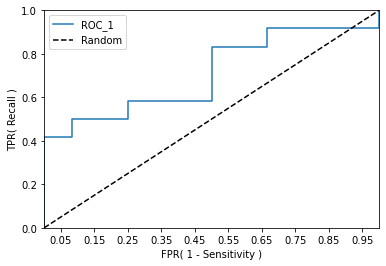

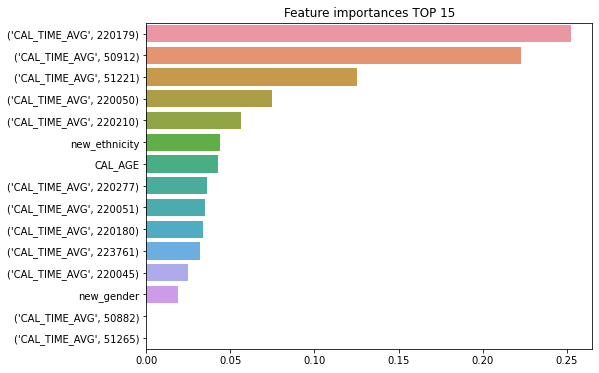

In [175]:
import pandas as pd
import numpy as np
final_input_table = pd.read_csv('./sungbin/9_2_final_4hour_check.csv')
# final_input_table.ETHNICITY.value_counts()
# final_input_table= final_input_table.iloc[:,:-2]
final_input_table

# 인종 레이블 인코딩
from sklearn.preprocessing import LabelEncoder



encoder=LabelEncoder()
encoder.fit(final_input_table.ETHNICITY)
labels = encoder.transform(final_input_table.ETHNICITY)
# print(labels)

final_input_table['new_ethnicity']=labels
final_input_table

# 성별 레이블 인코딩
encoder=LabelEncoder()
encoder.fit(final_input_table.GENDER)
gender = encoder.transform(final_input_table.GENDER)
# print(gender)

final_input_table['new_gender']=gender
final_input_table

encoding_input_table = final_input_table.drop(columns=['ETHNICITY','GENDER','renew_time','ICU','missing_value'])
encoding_input_table

encoding_input_table = encoding_input_table.reset_index(drop=False)
encoding_input_table

import random
idx_ls = list(encoding_input_table[encoding_input_table['class'] == 0.].index)
idx_ls_1 = list(encoding_input_table[encoding_input_table['class'] == 1.].index)
samp = random.sample(idx_ls, 60)
# print(len(samp))
# len(np.unique(samp))
samp += idx_ls_1
samp = np.array(samp)

# print(samp), len(samp)

samp_df = pd.DataFrame(samp, columns=['index'])
samp_df

down_samp_input = pd.merge(samp_df, encoding_input_table, on='index', how='inner')
down_samp_input = down_samp_input.drop(columns=['index'])
down_samp_input

# XGBoost
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score , recall_score , confusion_matrix, f1_score

import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')
from xgboost import plot_importance

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# dt_clf = DecisionTreeClassifier()
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
skfold = StratifiedKFold(n_splits=5)
n_iter = 0

features = down_samp_input.drop(columns=['class','new_time']).values
label = down_samp_input['class']


def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))



def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()
    
def roc_curve_plot_all(y_test, pred_proba_c1, n_iter):
    # 임계값에 따른 FPR, TPR값을 반환받음.
    fprs , tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # Roc 곡선 그림
    plt.plot(fprs, tprs, label=f'ROC_{n_iter}')
    # 가운데 대각선 직선을 그림
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale 을 0.1 단위로 변경, X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )'); plt.ylabel('TPR( Recall )')
    plt.legend()

def feature_importance(estimator):

    # feature importance
    ftr_importances_values = estimator.feature_importances_
    # print(ftr_importance_values)
    # Series로 변환
    ftr_importances = pd.Series(ftr_importances_values, index=down_samp_input.drop(columns=['class','new_time']).columns)

    # 중요도 순으로 정렬
    ftr_top15 = ftr_importances.sort_values(ascending=False)[:15]
    # print(ftr_top20)

    plt.figure(figsize=(8,6))
    plt.title('Feature importances TOP 15')
    sns.barplot(x=ftr_top15, y=ftr_top15.index)
    plt.show()

for train_index, test_index in skfold.split(features, label):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
    
    n_iter += 1
    print(f'##################################################################{n_iter} 번째 fold')
    
#     print('학습셋 라벨 분포 \n', y_train.value_counts())
#     print('테스트셋 라벨 분포 \n', y_test.value_counts(),'\n')
    
    
    
    # 학습 및 예측
    xgb_wrapper.fit(X_train, y_train)
    pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
    pred = xgb_wrapper.predict(X_test)
    
    # 반복 마다 평가하기
    roc_curve_plot_all(y_test, pred_proba, n_iter) # 그림
    roc_score = roc_auc_score(y_test, pred_proba)
#     print('ROC AUC 값 : {0:.4f}'.format(roc_score),'\n')
    print('기본적인 다른 평가:')
    get_clf_eval(y_test, pred, pred_proba)
    
    # feature importance 구하기
    feature_importance(xgb_wrapper)
    
    break

    
    
    
    

